In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.func import vmap, jacrev
from tqdm import tqdm
import os
import random
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import Callback
import math
from pydmd import DMD
from sklearn.preprocessing import MinMaxScaler
import warnings

In [2]:
class ResidualFlow(nn.Module):
    def __init__(self, dim, hidden_dim, n_layers, input_dim=0, dropout=0, LDJ=False):
        super(ResidualFlow, self).__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.LDJ = LDJ
        self.dropout = dropout
        
        layers = [nn.Linear(self.dim+self.input_dim, self.hidden_dim), nn.ReLU()]
        for _ in range(self.n_layers):
            layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(self.hidden_dim, self.dim))
        self.net = nn.Sequential(*layers)
        self._initialize_weights()
    
    def forward(self, x, u=None, reverse=False):
        def func(x_):
            x_e = torch.cat((x_, u), dim=-1) if u is not None else x_
            return self.net(x_e)
        if not reverse:   
            y = x + func(x)
            if self.LDJ:
                x = x.view(-1, x.shape[-1])
                jacobian = vmap(jacrev(func))(x)
                jacobian = jacobian.clone()  
                jacobian.diagonal(dim1=-2, dim2=-1).add_(1.0)
                _, logdet = torch.linalg.slogdet(jacobian)
                logdet = logdet.sum()
            else:
                logdet = 0
            return y, logdet
        else:
            y = x
            epsilon = 1e-4
            det = 1
            max_iter = 100
            with torch.no_grad():
                for _ in range(max_iter):
                    y_temp = y
                    y = x - func(y)
                    det = torch.norm(y - y_temp, dim=-1).max()
                    if det < epsilon:
                        break  
            return y
    
    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear): 
                nn.init.xavier_uniform_(module.weight) 
                if module.bias is not None:
                    nn.init.zeros_(module.bias)  

class InvertibleNN(nn.Module):
    def __init__(self, dim, hidden_dim, n_blocks, n_layers, input_dim=0, dropout=0, LDJ=False):
        super(InvertibleNN, self).__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.blocks = nn.ModuleList([ResidualFlow(self.dim, self.hidden_dim, self.n_layers, self.input_dim, dropout, LDJ) for _ in range(self.n_blocks)])
    
    def forward(self, x, u=None, reverse=False):
        if not reverse:
            ldj_total = 0
            for block in self.blocks:
                x, ldj = block(x, u, reverse)
                ldj_total += ldj
            return x, ldj_total
        else:
            for block in reversed(self.blocks):
                x = block(x, u, reverse)
            return x
        
class CombinedNetwork(nn.Module):
    def __init__(self, inn_model, input_dim, lifted_dim, Xmax, Xmin):
        super(CombinedNetwork, self).__init__()
        self.input_dim = input_dim
        self.inn_model = inn_model  
        self.Xmax = Xmax
        self.Xmin = Xmin
        self.dropout = nn.Dropout(p=inn_model.blocks[0].dropout)
        self.linear = nn.Linear(input_dim, lifted_dim, bias=False)  
        self._initialize_weights()
    
    def forward(self, x, u=None, reverse=False):
        x = x.float()
        Xmax = self.Xmax.to(x.device)
        Xmin = self.Xmin.to(x.device)
        if not reverse:
            x = (x - Xmin) / (Xmax - Xmin)
            chebyshev = torch.cos(self.linear(torch.arccos(x)))
            x = torch.cat((x, chebyshev), dim=-1)
            # x = self.dropout(x)
            x, ldj = self.inn_model(x, u, reverse)
            return x, ldj
        else:
            x = self.inn_model(x, u, reverse)
            x = x[:, :self.input_dim]
            x = (Xmax - Xmin) * x + Xmin
            return x
    
    def _initialize_weights(self):
        lambda_s = 5
        self.linear.weight.data = torch.distributions.exponential.Exponential(lambda_s).sample(self.linear.weight.shape)

In [3]:
def dmd(model, X, U, rank):
    GX_pred_list = []
    GX_list = []
    U_list = []
    GX, ldj = model(X, U.float())
    for i in range(X.shape[0]):
        GX_temp = GX[i, :, :].T
        dmd = DMD(svd_rank=rank, exact=True, sorted_eigs='abs')
        dmd.fit(GX_temp.cpu().detach().numpy())
        GX_pred = dmd.reconstructed_data.real
        GX_pred = np.array(GX_pred, dtype=np.float32)
        GX_pred = torch.from_numpy(GX_pred).cuda()
        GX_pred_list.append(GX_pred)
        GX_list.append(GX_temp)
        U_list.append(U[i, :, :].T)
    GX_pred = torch.cat(GX_pred_list, dim=-1)
    GX = torch.cat(GX_list, dim=1)
    U = torch.cat(U_list, dim=-1)

    return GX, GX_pred, U, ldj

In [4]:
class TrainModel(pl.LightningModule):
    def __init__(self, model, rank, learning_rate=1e-3, lamb=1, path="model_checkpoint_NP"):
        super(TrainModel, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = nn.MSELoss()
        self.best_val_loss = float('inf') 
        self.validation_outputs = []
        self.lamb = lamb
        self.train_losses = []
        self.rank = rank
        self.path = path+'.ckpt'

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        X_batch, U_batch = batch
        GY, GY_pred, _, ldj = dmd(self.model, X_batch, U_batch, self.rank)

        loss_lin = self.criterion(GY, GY_pred)
        loss_LDJ = ldj / X_batch.numel()

        loss = loss_lin - self.lamb * loss_LDJ
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        Z_batch, U_batch = batch
        Z1, Z_pred, U, _ = dmd(self.model, Z_batch, U_batch, self.rank)
        Z_pred = self.model(Z_pred.T, U.T, reverse=True)
        Z1 = self.model(Z1.T, U.T, reverse=True)
        valid_loss = self.criterion(Z_pred, Z1)

        self.validation_outputs.append(valid_loss)
        self.log('val_loss', valid_loss)
        return valid_loss

    def test_step(self, batch, batch_idx):
        Z_batch, U_batch = batch
        Z1, Z_pred, U, _ = dmd(self.model, Z_batch, U_batch, self.rank)
        Z_pred = self.model(Z_pred.T, U.T, reverse=True)
        Z1 = self.model(Z1.T, U.T, reverse=True)
        test_loss = self.criterion(Z_pred, Z1)

        self.log('test_loss', test_loss)
        return test_loss
    
    def on_fit_start(self):
        if self.trainer.is_global_zero: 
            if os.path.exists("loss_log.txt"):
                os.remove("loss_log.txt")
            if os.path.exists(self.path):
                os.remove(self.path)
    
    def on_train_batch_end(self, outputs, batch, batch_idx):
        with torch.no_grad():  
            for name, module in self.model.named_modules():  
                if isinstance(module, nn.Linear): 
                    if name == "linear":  
                        continue
                    weight = module.weight  
                    sigma_max = torch.norm(weight, p=2)  
                    if sigma_max > 1:  
                        scale = (1 - 1e-3) / sigma_max
                        module.weight.data *= scale  
    
    def on_train_epoch_start(self):
        if os.path.exists(self.path):
            best_state_dict = torch.load(self.path)["state_dict"]
            self.load_state_dict(best_state_dict)
    
    def on_train_epoch_end(self):
        if self.trainer.is_global_zero:  
            avg_train_loss = self.trainer.callback_metrics.get("train_loss")
            if avg_train_loss is not None:
                self.train_losses.append(avg_train_loss.item())
                print(f"Epoch {self.current_epoch}: Average Training Loss = {avg_train_loss.item()}")

    def on_validation_epoch_end(self):
        avg_val_loss = torch.stack(self.validation_outputs).mean()  
        self.log('avg_val_loss', avg_val_loss)
        self.validation_outputs.clear()
        print(f"Validation loss: {avg_val_loss}")
        with open("loss_log.txt", "a") as f:
            f.write(f"{avg_val_loss.item()}\n")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, eps=1e-08,
                                            weight_decay=0)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=1,
            gamma=0.92
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",  
            },
            "gradient_clip_val": 1.0, 
            "gradient_clip_algorithm": "norm",
        }

In [5]:
dim = 2 
hidden_dim = 20  
input_dim = 1
n_blocks = 10  
n_layers = 1
n_feature = 18
rank = 20
batch_size = 512
n_train = 10000
n_valid = 1000
n_test = 1000
dropout = 0
num_epochs = 100 
lamb = 0
learning_rate = 1e-3  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
X_train = pd.read_csv('limit_X_train.csv', header=None).values
X_valid = pd.read_csv('limit_X_valid.csv', header=None).values
X_test = pd.read_csv('limit_X_test.csv', header=None).values
U_train = pd.read_csv('limit_U_train.csv', header=None).values
U_valid = pd.read_csv('limit_U_valid.csv', header=None).values
U_test = pd.read_csv('limit_U_test.csv', header=None).values

length = X_train.shape[1] // n_train
HX_train = []
HU_train = []
for i in range(n_train):
    HX_train.append(X_train[:, i*length:(i+1)*length])
    HU_train.append(U_train[:, i*length:(i+1)*length])
HX_train = np.stack([HX_train[idx].T for idx in range(n_train)], axis=0)
HU_train = np.stack([HU_train[idx].T for idx in range(n_train)], axis=0)
HX_valid = []
HU_valid = []
for i in range(n_valid):
    HX_valid.append(X_valid[:, i*length:(i+1)*length])
    HU_valid.append(U_valid[:, i*length:(i+1)*length])
HX_valid = np.stack([HX_valid[idx].T for idx in range(n_valid)], axis=0)
HU_valid = np.stack([HU_valid[idx].T for idx in range(n_valid)], axis=0)
train_dataset = TensorDataset(torch.tensor(HX_train, dtype=torch.float32), torch.tensor(HU_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_dataset = TensorDataset(torch.tensor(HX_valid, dtype=torch.float32), torch.tensor(HU_valid, dtype=torch.float32))
valid_loader = DataLoader(valid_dataset, batch_size=99999, shuffle=True, num_workers=8, pin_memory=True)

X_result = np.concatenate([X_train, X_test, X_valid], axis=-1)
Xmax = torch.tensor(np.max(X_result, axis=-1), dtype=torch.float)
Xmin = torch.tensor(np.min(X_result, axis=-1), dtype=torch.float)

In [ ]:
warnings.filterwarnings("ignore")
path = "model_checkpoint_limit"
checkpoint_callback = ModelCheckpoint(
    monitor="avg_val_loss",   
    dirpath="./",
    filename=path,  
    save_top_k=1,  
    mode="min",    
)
inn_model = InvertibleNN(dim=dim+n_feature, hidden_dim=hidden_dim, n_blocks=n_blocks, n_layers=n_layers, input_dim=input_dim, dropout=dropout, LDJ=lamb>0)
model = CombinedNetwork(inn_model=inn_model, input_dim=dim, lifted_dim=n_feature, Xmax=Xmax, Xmin=Xmin)
lightning_model = TrainModel(model=model, rank=rank, learning_rate=learning_rate, lamb=lamb, path=path)
trainer = pl.Trainer(accelerator="gpu", devices=4, strategy="ddp_notebook", max_epochs=num_epochs, callbacks=[checkpoint_callback])

trainer.fit(lightning_model, train_loader, valid_loader)

In [7]:
inn_model = InvertibleNN(dim=dim+n_feature, hidden_dim=hidden_dim, n_blocks=n_blocks, n_layers=n_layers, input_dim=input_dim, dropout=dropout, LDJ=lamb>0)
model = CombinedNetwork(inn_model=inn_model, input_dim=dim, lifted_dim=n_feature, Xmax=Xmax, Xmin=Xmin)
path = "model_checkpoint_limit.ckpt"
lightning_model = TrainModel.load_from_checkpoint(path, model=model, rank=rank, learning_rate=learning_rate, map_location="cpu")
trainer = pl.Trainer(accelerator="gpu", devices=4, strategy="ddp_notebook", max_epochs=num_epochs)

/opt/conda/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.4.0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [8]:
length = X_test.shape[1] // n_test
HX_test = []
HU_test = []
for i in range(n_test):
    HX_test.append(X_test[:, i*length:(i+1)*length])
    HU_test.append(U_test[:, i*length:(i+1)*length])
HX_test = np.stack([HX_test[idx].T for idx in range(n_test)], axis=0)
HU_test = np.stack([HU_test[idx].T for idx in range(n_test)], axis=0)
test_dataset = TensorDataset(torch.tensor(HX_test, dtype=torch.float32), torch.tensor(HU_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=9999, shuffle=True)

In [ ]:
X_recons_list = []
for i in range(n_test):
    X_traj = HX_test[i, :61, :].reshape(1, 61, 2)
    U_traj = HU_test[i, :61, :].reshape(1, 61, 1)
    GY, GY_pred, U, _ = dmd(lightning_model.model, torch.tensor(X_traj, dtype=torch.float32), torch.tensor(U_traj, dtype=torch.float32), rank)
    X_recons = lightning_model.model(GY_pred.cpu().T, U.T, reverse=True).T.detach().numpy()
    X_recons_list.append(X_recons.T)
X_recons = np.stack(X_recons_list, axis=0)

In [12]:
np.mean((X_recons[:, 1:, :] - HX_test[:, 1:, :])**2)

0.0001846985922369753

In [10]:
np.save('mse_knif.npy', np.mean((X_recons[:, 1:, :] - HX_test[:, 1:, :])**2, axis=(0, 2)))

In [24]:
mse = np.load('mse_knif.npy')

In [13]:
i = 38
X_traj = HX_test[i, :61, :].reshape(1, 61, 2)
U_traj = HU_test[i, :61, :].reshape(1, 61, 1)
GY, GY_pred, U, _ = dmd(lightning_model.model, torch.tensor(X_traj, dtype=torch.float32), torch.tensor(U_traj, dtype=torch.float32), rank)
X_recons = lightning_model.model(GY_pred.cpu().T, U.T, reverse=True).T.detach().numpy()

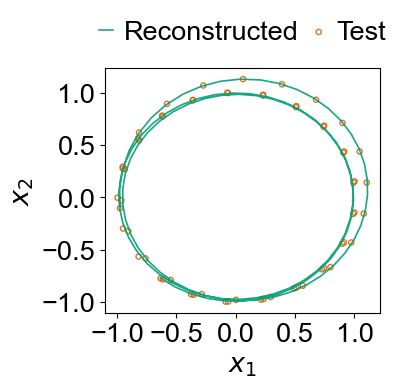

In [11]:
from matplotlib.font_manager import FontProperties
from scipy.interpolate import interp1d

arial_font = FontProperties(fname="/root/.fonts/arial.ttf", size=19.5)

scatter_color = '#D55E00'   
line_color = '#009E73'     

interp_factor = 2  

x_raw = np.arange(X_recons.shape[1])
x_new = np.linspace(x_raw.min(), x_raw.max(), X_recons.shape[1] * interp_factor)

f1 = interp1d(x_raw, X_recons[0], kind='cubic')
f2 = interp1d(x_raw, X_recons[1], kind='cubic')
smooth_x1 = f1(x_new)
smooth_x2 = f2(x_new)

plt.figure(figsize=(4, 4))

plt.plot(smooth_x1, smooth_x2, color=line_color, linewidth=1.2, alpha=0.9, label='Reconstructed')

plt.scatter(X_traj[0, :, 0], X_traj[0, :, 1],
            s=14, facecolors='none', edgecolors=scatter_color,
            linewidths=1.0, alpha=0.85, label='Test')

plt.xlabel('$x_1$', fontsize=19.5)
plt.ylabel('$x_2$', fontsize=19.5)
plt.xticks(fontsize=8, fontproperties=arial_font)
plt.yticks(fontsize=8, fontproperties=arial_font)

plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, 1.02),
    borderaxespad=0.3,
    ncol=2,
    columnspacing=0.5,
    handletextpad=0.4,
    handlelength=0.5,
    frameon=False,
    fontsize=8,
    prop=arial_font
)

plt.tight_layout()
plt.savefig("input2.svg", format='svg', bbox_inches='tight')
plt.show()

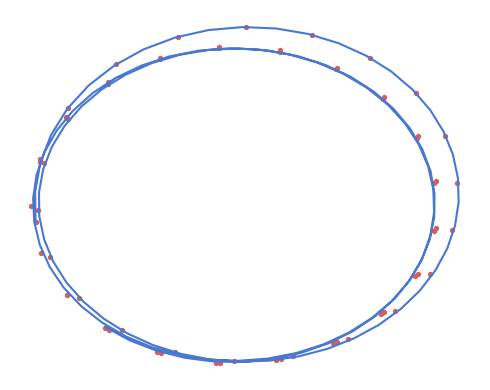

In [14]:
from matplotlib.font_manager import FontProperties
from scipy.interpolate import interp1d

arial_font = FontProperties(fname="/root/.fonts/arial.ttf", size=19.5)

scatter_color = '#D55E00'  
line_color = '#009E73'     

interp_factor = 2  

x_raw = np.arange(X_recons.shape[1])
x_new = np.linspace(x_raw.min(), x_raw.max(), X_recons.shape[1] * interp_factor)

f1 = interp1d(x_raw, X_recons[0], kind='cubic')
f2 = interp1d(x_raw, X_recons[1], kind='cubic')
smooth_x1 = f1(x_new)
smooth_x2 = f2(x_new)

plt.figure(figsize=(5, 4))

plt.plot(smooth_x1, smooth_x2, color="#4878CF", linewidth=1.5, label='Reconstructed')

plt.scatter(X_traj[0, :, 0], X_traj[0, :, 1],
            s=8, color="#D65F5F",
            linewidths=1.0, label='Test')

plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.gca().axis('off')
plt.savefig("b2.svg", format='svg', bbox_inches='tight')
plt.show()

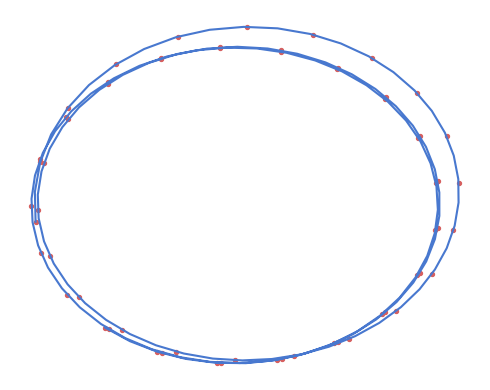

In [15]:
from matplotlib.font_manager import FontProperties
from scipy.interpolate import interp1d

arial_font = FontProperties(fname="/root/.fonts/arial.ttf", size=19.5)

scatter_color = '#D55E00'   
line_color = '#009E73'      

interp_factor = 2  

x_raw = np.arange(X_recons.shape[1])
x_new = np.linspace(x_raw.min(), x_raw.max(), X_recons.shape[1] * interp_factor)

f1 = interp1d(x_raw, X_traj[0, :, 0], kind='cubic')
f2 = interp1d(x_raw, X_traj[0, :, 1], kind='cubic')
smooth_x1 = f1(x_new)
smooth_x2 = f2(x_new)

plt.figure(figsize=(5, 4))

plt.plot(smooth_x1, smooth_x2, color="#4878CF", linewidth=1.5, label='Reconstructed')

plt.scatter(X_traj[0, :, 0], X_traj[0, :, 1],
            s=8, color="#D65F5F",
            linewidths=1.0, label='Test')

plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.gca().axis('off')
plt.savefig("b1.svg", format='svg', bbox_inches='tight')
plt.show()